<a href="https://colab.research.google.com/github/adamlutzz/DS-Unit-2-Applied-Modeling/blob/master/Fatal_Police_Encounters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fatal Police Shootings

In the past decade, few issues have been covered by national media as much as protests against police brutality. In January 2018 Vice News published a [story](https://news.vice.com/en_us/article/xwvv3a/shot-by-cops) on just how often police shootings are fatal. Vice also published their data on [github](https://github.com/vicenews/shot-by-cops). I found this dataset and wanted to see how accurate of a predictive model I could make given the data they provided.<br/>
<br/>
Below is a key for how Vice categorized race and gender. I will use the same key in my model.

**Race:**

*  W: White, non-Hispanic
*  B: Black, non-Hispanic
*  A: Asian
*  L: Latino
*  O: Other
*  U: Unknown<br/>

**Gender:**

*  M: Male
*  F: Female
*  U: Unknown

### Installations

In [104]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:

    # Install required python packages
    !pip install -r 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/requirements.txt'

### Pre-processing

In [105]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

# link from vice github
link = 'https://raw.githubusercontent.com/vicenews/shot-by-cops/master/subject_data.csv'

# read in 
df = pd.read_csv(link)

# check df shape
print(df.shape)

# first look at df
df.head()

(4400, 16)


,Date,NumberOfSubjects,Fatal,SubjectArmed,SubjectRace,SubjectGender,SubjectAge,NatureOfStop,NumberOfShots,NumberOfOfficers,OfficerRace,OfficerGender,Department,FullNarrative,City,Notes
0,3/4/2010,1,N,N,L,U,U,NaN,NaN,1,W,M,Albuquerque Police Department,NaN,Albuquerque,motorized vehicle; no hits
1,1/9/2010,1,F,Y,W,M,U,NaN,NaN,1,W,M,Albuquerque Police Department,NaN,Albuquerque,NaN
2,6/10/2010,1,F,Y,W,M,U,NaN,NaN,2,W;W,M;M,Albuquerque Police Department,NaN,Albuquerque,NaN
3,11/10/2010,1,N,Y,U,M,U,NaN,NaN,1,W,M,Albuquerque Police Department,NaN,Albuquerque,NaN
4,11/11/2010,1,N,Y,L,M,U,NaN,NaN,1,W,M,Albuquerque Police Department,NaN,Albuquerque,NaN


In [0]:
# target category is 'Fatal'
target = 'Fatal'

# make column for pretty graph
targ_dic = {'F': 'Fatal', 'N': 'Non-Fatal', 'U': 'Unknown'}

In [107]:
# lets see how balanced our class is
print(df[target].value_counts())
df[target].value_counts(normalize=True)

N     2719
F     1379
U      288
 N      11
 F       3
Name: Fatal, dtype: int64


N     0.617955
F     0.313409
U     0.065455
 N    0.002500
 F    0.000682
Name: Fatal, dtype: float64

It looks like I will need to clean these up. However there are likely 3 classes<br/>
N - non-fatal<br/>
F - Fatal<br/>
U - Unknown<br/>

In [108]:
# remove space
df['Fatal'] = df[target].str.strip()

# apply target dictionary and make new feature
base_df = pd.DataFrame(df[target].value_counts())

base_df = base_df.rename(index=targ_dic)

# base_df = base_df.reset_index()

base_df.head()

,Fatal
Non-Fatal,2730
Fatal,1382
Unknown,288


In [109]:
# base_df = base_df.rename(columns={'index':'class'})
base_df.head()

,Fatal
Non-Fatal,2730
Fatal,1382
Unknown,288


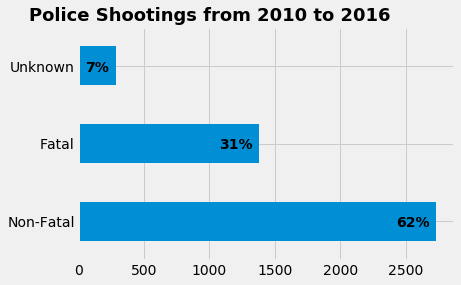

In [110]:
# visualize
ax = base_df.plot.barh()
plt.style.use('fivethirtyeight')
plt.title('Police Shootings from 2010 to 2016', fontsize=18, fontweight='bold',x=.35)
ax.text(x=2425,y=-.07,s='62%', fontsize=14, fontweight='bold')
ax.text(x=1075,y=.93,s='31%', fontsize=14, fontweight='bold')
ax.text(x=50,y=1.93,s='7%', fontsize=14, fontweight='bold')
ax.get_legend().remove()
plt.show()

### Calculate Baseline

In [111]:
from sklearn.model_selection import train_test_split

# do a train test split
train, test = train_test_split(df, test_size=.2, random_state=11)

train.shape, test.shape

((3520, 16), (880, 16))

In [112]:
# split again for validation
train, val = train_test_split(train, test_size=.2, random_state=11)

train.shape, val.shape

((2816, 16), (704, 16))

In [113]:
# divide into X features matrix and y target vector
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns=target)

# y target vector
y_train = train[target]
y_val = val[target]
y_test = test[target]

# verify shape
X_train.shape, y_train.shape

((2816, 15), (2816,))

In [114]:
from sklearn.impute import SimpleImputer

# create quick baseline model
base_RF = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_jobs=-1, random_state=11)
)
# Fit on train, score on val
base_RF.fit(X_train, y_train)
y_pred = base_RF.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Validation Accuracy 0.6505681818181818


.65 is only 3% more than the majority class so I think it is safe to say that this model is very weak right now.

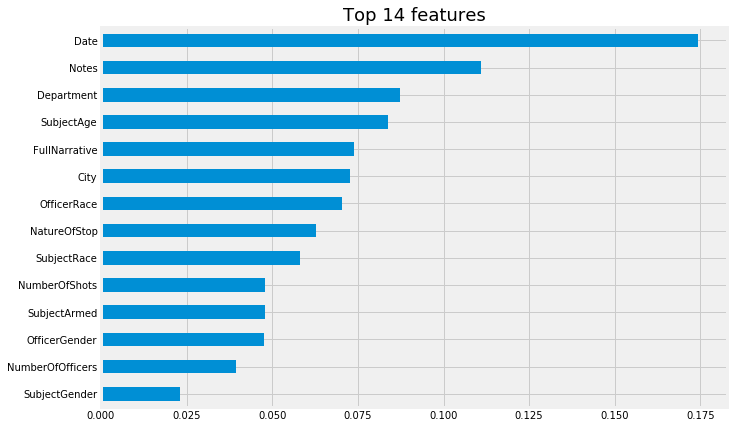

In [115]:
# Get feature importances
rand_f = base_RF.named_steps['randomforestclassifier']
importances = pd.Series(rand_f.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 14
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features', fontsize=18)
importances.sort_values()[-n:].plot.barh()
plt.show()

Lets keep an eye on this and see how it changes as we wrangle the data

### Pandas Profiling Report

In [116]:
import pandas_profiling

df.profile_report()

/usr/local/lib/python3.6/dist-packages/pandas_profiling/model/correlations.py:124: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The internally computed table of expected frequencies has a zero element at (0, 16).')
  correlation_name=correlation_name, error=error


### Feature Exploration

In [117]:
# This is explained above, but I wanted a quick reference
df.dtypes

Date                object
NumberOfSubjects     int64
Fatal               object
SubjectArmed        object
SubjectRace         object
SubjectGender       object
SubjectAge          object
NatureOfStop        object
NumberOfShots       object
NumberOfOfficers    object
OfficerRace         object
OfficerGender       object
Department          object
FullNarrative       object
City                object
Notes               object
dtype: object

**To-Do's**


*   Change date to datetime format (X)
*   Split features into ordnial and nominal (~)
*   Figure out how to best impute NA's (~)
*   Identify High Cardinality features and investigate binning (~)
*   Clean up number of shots (should be int) try using bins (~)
*   Drop 'NumberofSubjects' - it is a constant (X)
*   SubjectAge into bins 10-19 etc. (-)
*   IsMale new feature counts how many male officers involved (X)
*   IsFemale new feature counting how many female officers involved (X)
*   IsUknown for unknown Gender (X)
*   Bin top 10 nature of stops? (-)
*   Make a feature for each officer race and count how many (~) couldn't figure it out
*   Group observations that only have year and no day (X)
*   Make Dictionary for all classes in low-cardinality features (X)




In [118]:
# in the profile report there were 5 unique values including NA so lets check it out
df['SubjectArmed'].value_counts()

# looks like extra spaces will need to be removed

Y     1661
N     1215
U      938
Y        3
Name: SubjectArmed, dtype: int64

In [0]:
# figure out number of shots (binning)

In [0]:
# convert date to datetime
def datetime(df):
  # prevent warning
  df = df.copy()

  # convert to date-time
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

  return df

In [0]:
# declare list of columns you want to edit
wrangle_col = ['SubjectAge', 'OfficerGender',
                'OfficerRace', 'SubjectGender',
                'SubjectRace']

# create dictionary of bad characters
bad_chars = {'/':'', ':':';', ' ':'', 'H':'L'}

# wrangle function
def wrangle(df):
  
  df = df.copy()

  # strip out leading and trailing spaces
  for col in df[wrangle_col]:
    df[col] = df[col].str.strip()

  # replace un-uniform characters
  for col in df[wrangle_col]:
    for char in bad_chars:
      df[col] = df[col].str.replace('/', '')
      df[col] = df[col].str.replace(':', ';')
      df[col] = df[col].str.replace(' ', '')
      df[col] = df[col].str.replace('H', 'L')
      df[col] = df[col].str.replace('OtLer', 'Other')
      df[col] = df[col].str.replace('WLITE', 'WHITE')
  
  # make a list feature of these
  # df['OfficerGenderList'] = df['OfficerGender'].str.split(pat=';')

  # df['OfficerRaceList'] = df['OfficerRace'].str.split(pat=';')

  # pull out month day and year for df
  df['year_recorded'] = df['Date'].dt.year
  df['month_recorded'] = df['Date'].dt.month
  df['day_recorded'] = df['Date'].dt.day
  df = df.drop(columns='Date')
  df = df.drop(columns='NatureOfStop')
  df = df.drop(columns='Notes')
  df = df.drop(columns='NumberOfSubjects')

  return df

In [0]:
# I took some liberty with excel to parse through this data to find actual classes
gen_class = {'OfficerIsMale':'M', 'OfficerIsFemale':'F', 'OfficerIsUnknown':'U'}


'''In interest of the deadline this portion of encoding will have to be put on hold until further notice

# race_class = {'White':['W', 'WHITE'],
#               'Black':['B', 'BLACK'],
#               'Unknown':['U', 'Unknown'],
#               'Latino':['L', 'LL'],
#               'Asian':['A', 'ASAIN'],
#               'Other':['O, WL, WA, NAW, API, AW, AIAN, WL, APIUnknown, mm, Other, M, Multi-Racial, I']
#               }

# race_class = {'OfficerWhite':'W',
#               'OfficerBlack':'B',
#               'OfficerUnknown':'U',
#               'OfficerLatino':'L',
#               'OfficerOther':'O',
#               'OfficerAsian':'A',
#               'OfficerLatino':'LL',
#               'OfficerOther':'WL',
#               'OfficerOther':'WA',
#               'OfficerOther':'NAW',
#               'OfficerOther':'API',
#               'OfficerOther':'AW',
#               'OfficerOther':'AIAN',
#               'OfficerOther':'WL',
#               'OfficerWhite':'WHITE',
#               'OfficerBlack':'BLACK',
#               'OfficerOther':'APIUnknown',
#               'OfficerOther':'Other',
#               'OfficerOther':'mm',
#               'OfficerAsian':'ASIAN',
#               'OfficerOther':'Other',
#               'OfficerOther':'M',
#               'OfficerOther':'Multi-Racial',
#               'OfficerUnknown':'Unknown',
#               'OfficerOther':'I'}
# right now the problem with this is that is is likely writing over itself ruining my count'''


# def encoding function
def to_encode(df):

  df = df.copy()

  # loop through cols and encode
  for gender in gen_class:
    df[gender] = df['OfficerGender'].str.count(gen_class[gender])
  
  # for race in race_class:
  #   df[race] = df['OfficerRace'].str.count(race_class[race])
  
  return df


In [0]:
# def pre-processing function
def pre_process(df):

  df = df.copy()

  # apply functions
  df = datetime(df)
  df = wrangle(df)
  df = to_encode(df)

  return df

In [0]:
#  apply function
 X_train = pre_process(X_train)
 X_val = pre_process(X_val)
 X_test = pre_process(X_test)

In [125]:
X_train.head(10)

,SubjectArmed,SubjectRace,SubjectGender,SubjectAge,NumberOfShots,NumberOfOfficers,OfficerRace,OfficerGender,Department,FullNarrative,City,year_recorded,month_recorded,day_recorded,OfficerIsMale,OfficerIsFemale,OfficerIsUnknown
1920,Y,B,U,U,NaN,1,B,M,Houston Police Department,HPD officers patrolling 10 District observed t...,Houston,2013,9,26,1,0,0
1711,N,B,U,U,NaN,1,L,M,Houston Police Department,"Three suspects fled in a vehicle, they pointed...",Houston,2015,7,7,1,0,0
882,N,B,M,U,NaN,NaN,BLACK,MALE,Cincinnati Police Department,NaN,Cincinnati,2012,2,23,1,0,0
1149,N,B,M,28,3,1,W,M,Dallas Police Department,http://dallaspolice.net/reports/OIS/narrative/...,Dallas,2011,5,8,1,0,0
430,U,L,M,20-29,NaN,1,W,M,Chicago Police Department,NaN,Chicago,2012,12,10,1,0,0
2400,U,L,M,U,NaN,11,B;L;L;L;L;L;L;W;W;W;W,M;M;M;M;M;M;M;M;M;M;M,Los Angeles Police Department,NaN,LosAngeles,2012,6,14,11,0,0
511,Y,W,U,U,4,1,L,M,Chicago Police Department,NaN,Chicago,2016,9,4,1,0,0
635,U,L,M,20-29,10,1,W,M,Chicago Police Department,NaN,Chicago,2010,2,15,1,0,0
426,U,B,M,19,14,1,B,M,Chicago Police Department,NaN,Chicago,2012,8,9,1,0,0
1769,N,L,M,29,NaN,2,W;W,M;M,Houston Police Department,An armed domestic violence suspect ran from th...,Houston,2010,11,30,2,0,0


In [126]:
# re-run model
rerun_RF = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_jobs=-1, random_state=11)
)
# Fit on train, score on val
rerun_RF.fit(X_train, y_train)
y_pred = rerun_RF.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Validation Accuracy 0.671875


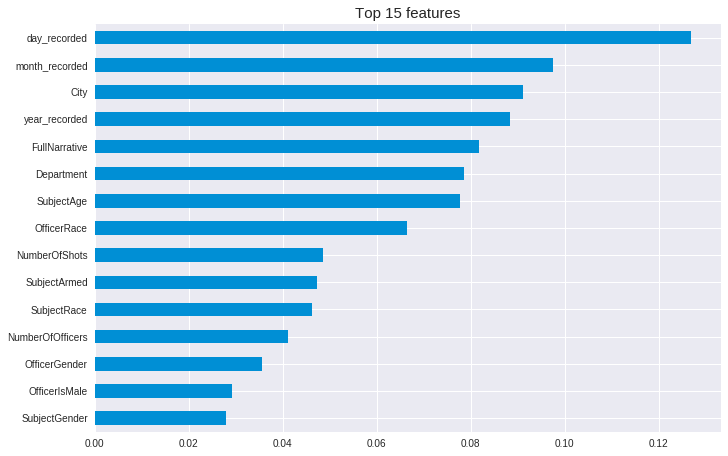

In [127]:
# Get feature importances
rand_f = rerun_RF.named_steps['randomforestclassifier']
importances = pd.Series(rand_f.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 15
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features', fontsize=15)
importances.sort_values()[-n:].plot.barh();

In [0]:
# transform and set model for eli5
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

# apply transformation pipeline for X_train and X_val
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

In [129]:
model = RandomForestClassifier(n_jobs=-1, random_state=11)
model.fit(X_train_transformed, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

In [130]:
import eli5
from eli5.sklearn import PermutationImportance

# instantiate permuter
permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=2,
    random_state=11
)

# fit permuter
permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

# show weights
eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Using TensorFlow backend.


Weight,Feature
0.0433 ± 0.0128,City
0.0277 ± 0.0099,Department
0.0213 ± 0.0085,SubjectGender
0.0185 ± 0.0000,OfficerGender
0.0178 ± 0.0014,SubjectRace
0.0163 ± 0.0270,day_recorded
0.0092 ± 0.0043,OfficerIsUnknown
0.0085 ± 0.0000,SubjectArmed
0.0064 ± 0.0014,year_recorded
0.0064 ± 0.0043,SubjectAge


In [131]:
# Remove features with zero or less feature importance
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

X_train.shape

(2816, 15)

In [132]:
# apply to validation as well
X_val = X_val[features]
X_val.shape

(704, 15)

In [133]:
# build new pipeline and use features without 0 weight features
RF_reformed = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_jobs=-1, random_state=11)

)

# score
RF_reformed.fit(X_train, y_train)
print ('Validation Accuracy', RF_reformed.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Validation Accuracy 0.6576704545454546


**Challenges**<br/>
There were some obvious challenges with this dataset. The most obvious one being inconsistancy in reported data. This makes sense considering this information was gathered from 47 different police departments across the United States. With the amount of variance in data types for each feature. It made it very difficult to make a predictive model that predicts much better than the majority class. At this point the model is about 7% higher than the baseline for this dataset.

### Feature Engineering

A simple experiment can be run to see if race plays a significant role in the predictive power of this model. Engineering a feature called 'SubjectMinority' may provide some insight in this. After the model is re-run with the added feature, accuracies can be compared to explain the relationship.

In [0]:
minorites = ['B', 'L', 'A', 'O', 'U']

# make minority features
def minority_feature(df):

  df = df.copy()

  # logic for subject minority
  df['MinorityClass'] = np.where(df['SubjectRace'] != 'W', 1, 0)

  return df

In [0]:
#  run function
 X_train = minority_feature(X_train)
 X_val = minority_feature(X_val)
 X_test = minority_feature(X_test)

In [136]:
# visualize engineered feature
X_train.head()

,SubjectArmed,SubjectRace,SubjectGender,SubjectAge,NumberOfShots,NumberOfOfficers,OfficerRace,OfficerGender,Department,FullNarrative,City,year_recorded,day_recorded,OfficerIsMale,OfficerIsUnknown,MinorityClass
1920,Y,B,U,U,NaN,1,B,M,Houston Police Department,HPD officers patrolling 10 District observed t...,Houston,2013,26,1,0,1
1711,N,B,U,U,NaN,1,L,M,Houston Police Department,"Three suspects fled in a vehicle, they pointed...",Houston,2015,7,1,0,1
882,N,B,M,U,NaN,NaN,BLACK,MALE,Cincinnati Police Department,NaN,Cincinnati,2012,23,1,0,1
1149,N,B,M,28,3,1,W,M,Dallas Police Department,http://dallaspolice.net/reports/OIS/narrative/...,Dallas,2011,8,1,0,1
430,U,L,M,20-29,NaN,1,W,M,Chicago Police Department,NaN,Chicago,2012,10,1,0,1


In [137]:
# re-run model
engineer_RF = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_jobs=-1, random_state=11)
)
# Fit on train, score on val
engineer_RF.fit(X_train, y_train)
y_pred = engineer_RF.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Validation Accuracy 0.6576704545454546


While the accuracy did improve. It was not by much. Without looking at feature importances it will be hard to make a claim in either direction.

In [138]:
# Hyperparameter tuning
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

# make pipeline
engineer_RF = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(random_state=11)
)

# set parameter ranges
param_distributions = { 
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    engineer_RF, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   27.7s finished


In [139]:
print('Best hyperparameters', search.best_params_)
print('Accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.5603501870978566, 'randomforestclassifier__n_estimators': 128, 'simpleimputer__strategy': 'mean'}
Accuracy 0.6722301136363636


In [140]:
# re-run model
hyper_RF = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(max_depth=5, max_features=0.5811397941970669, n_estimators=379, n_jobs=-1, random_state=11)
)
# Fit on train, score on val
hyper_RF.fit(X_train, y_train)
y_pred = hyper_RF.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.6903409090909091


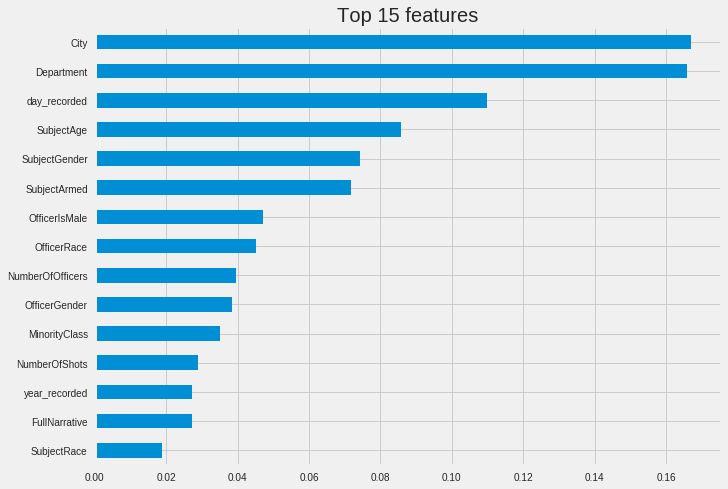

In [146]:
# Get feature importances
rand_f = hyper_RF.named_steps['randomforestclassifier']
importances = pd.Series(rand_f.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

n = 15
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [0]:
# transform and set model for eli5
e_transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

# apply transformation pipeline for X_train and X_val
X_train_etransformed = e_transformers.fit_transform(X_train)
X_val_etransformed = e_transformers.fit_transform(X_val)

In [143]:
e_model = RandomForestClassifier(max_depth=10, max_features=0.22451179153616552, n_estimators=459, n_jobs=-1, random_state=11)
e_model.fit(X_train_etransformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=0.22451179153616552,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=459, n_jobs=-1, oob_score=False,
                       random_state=11, verbose=0, warm_start=False)

In [144]:
import eli5
from eli5.sklearn import PermutationImportance

# instantiate permuter
permuter = PermutationImportance(
    e_model, 
    scoring='accuracy',
    n_iter=2,
    random_state=11
)

# fit permuter
permuter.fit(X_val_etransformed, y_val)
feature_names = X_val.columns.tolist()

# show weights
eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.0227 ± 0.0057,SubjectAge
0.0220 ± 0.0043,day_recorded
0.0206 ± 0.0043,SubjectArmed
0.0185 ± 0.0000,SubjectGender
0.0170 ± 0.0057,NumberOfOfficers
0.0156 ± 0.0000,year_recorded
0.0149 ± 0.0099,City
0.0128 ± 0.0114,Department
0.0043 ± 0.0085,OfficerGender
0.0043 ± 0.0057,OfficerRace


It is pretty easy to infer from this that the more heavily weighted features are generic attributes that are most likely applicable in every case. <br/>
Comparing models from multiple cities may a better understanding of the impact of specific features like race (subject and officer). 

### Questions/Issues

Right now I having troubles with the variance in each class. I have tried to break things out as best I can without adding bias into the dataset but it is proving to be very difficult. Because of this I am trying to pull out as much as I can from the features I am confident will not introduce bias into my model. While I have increased my accuracy it is not even 10% more the the majority class so that is a bit frustrating.